# Who needs spectral bands? We do. Some baby steps ...

____________
<a id='section1'></a>

## 1. The two-stream Schwarschild equations
____________

Here we are going to introduce the governing equations of radiative transfer to put what we've been doing on a more solid theoretical footing.

Our derivations here will also serve as a coherent documentation for how some of the radiation solvers are implemented in `climlab`.

### Optical thickness

The **optical thickness** of a layer of absorbers is $\Delta \tau_\nu$. It is the emissivity and absorptivity of a layer of atmosphere.

Passing to the limit of very thin layers, we define $\tau_\nu$ through

$$ \frac{d \tau_\nu}{dp} = -\frac{1}{g} \kappa_\nu $$

where **$\kappa_\nu$ is an absorption cross-section** per unit mass at frequency $\nu$. It has units m$^2$ kg$^{-1}$. $\kappa$ is a measure of the area taken out of the incident beam by absorbers in a unit mass of atmosphere.

In general **$\tau_\nu$ depends on the frequency of the radiation**, as indicated here by the subscript $\nu$.

### Using optical depth as vertical coordinate

Since pressure decreases with altitude, $\tau_\nu$ increases with altitude.

The equations of radiative transfer can be simplified by using $\tau_\nu$ as vertical coordinate instead of pressure.

### Absorption cross-section

The specific absorption cross section $\kappa$ depends on the number of molecules of each greenhouse gas encountered by the beam and the absorption properties characteristic to each kind of greenhouse gas molecule. Letting $q_k$ be the mass-specific concentration of greenhouse gas $k$, we may write in general

$$ \kappa(\nu, p, T) = \sum_{k=1}^n \kappa_k\big(\nu, p, T \big) q_k(p) $$

For a well-mixed greenhouse gas, $q_k$ is a constant; for a non-well-mixed gas like water vapor we need to account for the vertical distribution of the gas through $q_k(p)$.

The dependence of $\kappa_k$ on temperature and pressure arises from certain aspects of the physics of molecular absorption. 

### Two-stream Schwarzschild equations

For climate modeling we almost always seperate the total flux into two beams: **upward** and **downward**. 

This involves taking integrals of the full angular dependence of the flux. We'll skip the details here.

Let $U_\nu$ be the upward beam, and $D_\nu$ be the downward beam. The governing equations for these beams are the *Schwarzschild equations*:

$$
\begin{align}
\frac{d U_\nu}{d \tau_\nu} &= -U_\nu + E\big( \nu, T(\tau_\nu) \big) \\
\frac{d D_\nu}{d \tau_\nu} &= D_\nu - E\big( \nu, T(\tau_\nu) \big) 
\end{align}
$$

where $E$ is the **blackbody emission** (both up and down), which in general depends on both **frequency** and **temperature**. We have written temperature as a function of the vertical coordinate (optical depth). 

The emissions are governed by the **Planck function**:

$$
\begin{align}
E &= \pi~ B\big( \nu, T \big) \\
B\big( \nu, T \big) &= \frac{2 h \nu^3}{c^2} \frac{1}{\exp \left( \frac{h \nu}{k T} \right) -1} 
\end{align}
$$

with these fundamental physical constants:

- $h = 6.626 \times 10^{-34} ~\text{J s} $ is Planck's constant
- $c = 3.00 \times 10^8 ~\text{m s}^{-1} $ is the speed of light
- $k = 1.38 \times 10^{-23} ~\text{J K}^{-1} $ is the Boltzmann Thermodynamic Constant

The two-stream equations basically say the beam is **attenuated by absorption** (first term) and **augmented by emission** (second term) in each thin layer of gas.

These equations are valid for beam that are **not affected by scattering**. We may come back to that later.

____________
<a id='section2'></a>

## 2. The Grey Gas Model
____________

The absorption properties $\kappa_i$ of most atmospheric gases varies enormously with the frequency of the radiation. Hence the optical thickness $\tau_\nu$ also has an intricate dependence on wavenumber or frequency. 

Our job as climate modelers is to calculate and understand the net atmospheric absorption and transmission of radiation. To do this thoroughly and accurately, the fluxes must be solved for individually on a very dense grid of wavenumbers, and then the results integrated over all wavenumbers.

Actual radiative transfer codes (as used in GCMs) apply a lot of tricks and shortcuts to simplify this brute-force approach, but lead to sets of equations that are difficult to understand.

However, there is a lot we can understand about the basics of radiative transfer and the greenhouse effect by ignoring the spectral dependence of the flux.

Specifically, we make the approximation

$$ \kappa(\nu, p, T) = \kappa(p) $$

so that the optical depth $\tau$ is now **independent of frequency**.

This is known as the **grey gas approximation**.

## Grey gas versions of the Schwarzschild equations

### Integrating the Planck function

If we assume $\tau_\nu$ is independent of frequency, we can then integrate the two-stream equations over all frequencies.

The integral of the Planck function gives our familiar Stefan-Boltzmann blackbody radiation law

$$ E(T) = \int_0^{\infty} \pi B\big( \nu, T \big) d\nu = \sigma T^4  $$

with 

$$ \sigma = \frac{2 \pi^5 k^4}{15 c^2 h^3} = 5.67 \times 10^{-8} ~\text{W m}^{-2}~\text{K}^{-4}$$

In [1]:
# climlab has these constants available, and actually calculates sigma from the above formula
import numpy as np
import climlab 

sigma = ((2*np.pi**5 * climlab.constants.kBoltzmann**4) / 
         (15 * climlab.constants.c_light**2 * climlab.constants.hPlanck**3) )
print( sigma)
sigma == climlab.constants.sigma

5.6703726225913323e-08


True

### The grey gas equations

This gives the governing equations for the grey gas model:

$$
\begin{align}
\frac{d U}{d \tau} &= -U + \sigma T(\tau)^4 \\
\frac{d D}{d \tau} &= D - \sigma T(\tau)^4 
\end{align}
$$

These equations now say that the beam is diminished by absorption in a thin layer (first term) and augmented by blackbody emission, where both processes are assumed to be independent of frequency.

### How do the fluxes change across a finite layer of absorbers?

The above equations are **linear, first order ODEs**, and they are uncoupled from each other (because we neglected scattering).

**Consider a layer of atmosphere** from optical level $\tau_{0}$ to $\tau_{1}$. The optical thickness of the layer is $\Delta \tau = \tau_{1} - \tau_{0}$.

The incident upwelling beam from below is denoted $U_{0}$; the upwelling beam that leaves the top of our layer is denoted $U_{1}$. We want to calculate $U_{1}$, which we can get by integrating the equation for $dU/d\tau$ over our layer.

The result is

$$ U_{1} = U_{0} \exp(-\Delta \tau) + \int_{\tau_{0}}^{\tau_{1}} E \exp \big( -(\tau_{1} - \tau) \big) d\tau $$

where $\tau$ is now a dummy variable of integration, and we've written the blackbody emissions as $E = \sigma T^4$.

The change in the downwelling beam is similar:

$$ D_{0} = D_{1} \exp(-\Delta \tau ) + \int_{\tau_0}^{\tau_1} E \exp\big( -(\tau - \tau_{0}) \big) d\tau $$

____________
<a id='section3'></a>

## 3. What if CO$_2$ actually behaved like a Grey Gas?
____________

Suppose that CO$_2$ actually behaved as a grey gas. In other words, no spectral dependence in absorptivity.

If we then **double the CO2 concentration** in the atmosphere, we double the number of absorbers. This should imply that we also **double the absorption cross-section** $\kappa$. Following the notation above, we have:

$$ \kappa^\prime = 2 ~ \kappa $$

This would imply that we **double the optical thickness of every layer**:

$$ \Delta \tau^\prime  = 2 \left( -\frac{\kappa}{g} \Delta p \right) = 2 ~ \Delta \tau$$ 

where here I have written optical thickness in discrete form.

And since the absorptivity/emissivity of each layer is

$$  \epsilon = 1 - \exp\big( - \Delta \tau \big)  $$

which we can get from integrating the grey gas versions of the Schwarzschild equations, the **modified absorptivity** is

$$ \epsilon^\prime = 1 - \exp\big( - 2\Delta \tau \big) = 1 - \left( \exp\big( - \Delta \tau \big)\right)^2 = 1 - (1-\epsilon)^2 $$

or simply

$$ \epsilon^\prime = 2 \epsilon  - \epsilon^2 $$

(Note that $\epsilon^\prime = 2 \epsilon$ for very thin layers, for which $\epsilon$ is small).

### What does our 2-layer analytical model then say about the radiative forcing?

Recall that [we tuned the two-layer grey gas model](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/elementary-greenhouse.html#tuning-the-grey-gas-model-to-observations) with

$$ \epsilon = 0.586 $$

to get the observed OLR with observed temperatures.

In [37]:
#  Applying the above formula
eps = 0.586
print(f'Doubling a grey gas absorber would change the absorptivity from {eps:.3} to {2*eps - eps**2:.3}')

Doubling a grey gas absorber would change the absorptivity from 0.586 to 0.829


**If CO2 behaved like a grey gas**, doubling it would cause a huge increase in the absorptivity of each layer!

[We previously worked out that the radiative forcing in this model](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/elementary-greenhouse.html#the-radiative-forcing-change-in-olr-depends-on-the-lapse-rate) (with the observed lapse rate) is about +2.6 W m$^{-2}$ for a 2% increase in $\epsilon$.

In [3]:
forcing_rate = 2.6 / 0.02   # W/m2 forcing per fractional increase in epsilon

Our hypothetical doubling of "grey CO$_2$" yields an increase from 0.586 to 0.829, or more than 40%:

In [38]:
fractional_increase = (0.829 - 0.586) / 0.586
print(fractional_increase)

0.41467576791808874


So roughly speaking, this should yield a radiative forcing 20 times larger than +2.6 W m$^{-2}$:

In [5]:
radiative_forcing = forcing_rate * fractional_increase  # W/m2
print(radiative_forcing)

53.907849829351534


**Our hypothetical doubling of "grey CO$_2$" gives a radiative forcing greater than 50 W m$^{-2}$.** 

This is an absolutely enormous number. Assuming a [net climate feedback of -1.3 W m$^{-2}$ K$^{-1}$](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/sensitivity-feedback.html#feedbacks-diagnosed-from-complex-climate-models) (consistent with the CMIP5 model ensemble)
would then give us a truly astronomical **equilibrium climate sensitivity of 41 K**:

In [6]:
lambda_net = -1.3  #  W/m2/K
ecs = radiative_forcing / -(lambda_net)  # K
print(ecs)

41.467576791808874


### Conclusions:

1. **If CO2 did behave like a grey gas, we would be toast\*!** 
2. The Grey Gas model is insufficient for understanding radiative forcing and feedback.

\* *Phrase borrowed with great respect from [R. Pierrehumbert (2010), Principles of Planetary Climate, Cambridge University Press.](https://geosci.uchicago.edu/~rtp1/PrinciplesPlanetaryClimate/), which is easily to best textbook that exists on this subject.*

____________
<a id='section4'></a>

## 4. Another look at observed spectra
____________

It's time to move away from the Grey Gas approximation and look more carefully at the actual observed spectra of solar and terrestrial radiation.

### Observed solar spectra

The following figure shows observed spectra of solar radiation at TOA and at the surface, along with the theoretical Planck function for a blackbody at 5525 K.

<img src='https://upload.wikimedia.org/wikipedia/commons/e/e7/Solar_spectrum_en.svg'>

> This figure shows the solar radiation spectrum for direct light at both the top of the Earth's atmosphere and at sea level. The sun produces light with a distribution similar to what would be expected from a 5525 K (5250 °C) blackbody, which is approximately the sun's surface temperature. As light passes through the atmosphere, some is absorbed by gases with specific absorption bands. Additional light is redistributed by Rayleigh scattering, which is responsible for the atmosphere's blue color. These curves are based on the American Society for Testing and Materials (ASTM) Terrestrial Reference Spectra, which are standards adopted by the photovoltaics industry to ensure consistent test conditions and are similar to the light that could be expected in North America. Regions for ultraviolet, visible and infrared light are indicated.

Source: http://commons.wikimedia.org/wiki/File:Solar_spectrum_en.svg

- The figure shows that that the incident beam at TOA has the shape of a blackbody radiator. 
- By the time the beam arrives at the surface, it is strongly depleted at specific wavelengths.
- Absorption by O$_3$ (ozone) depletes almost the entire ultraviolet spectrum.
- Weaker absorption features, mostly due to H$_2$O, deplete some parts of the near-infrared.
- Note that the depletion in the visible band is mostly due to scattering, which depletes the direct beam but contributes diffuse radiation (so we can still see when it's cloudy!)

### Observed terrestrial spectra

This figure shows the Planck function for Earth's surface temperature compared with the spectrum observed from space.

![Terrestrial spectrum](../images/Terrestrial_spectrum.png)

Source: David Bice, Penn State University. https://www.e-education.psu.edu/earth103/node/1006

Careful: I'm pretty sure what is plotted here is not the **total** observed spectrum, but rather the part of the **emissions from the surface** that **actual make it out to space**.

As we know, the terrestrial beam from the surface is depleted by absorption by many greenhouse gases, but principally CO$_2$ and H$_2$O.

However there is a spectral band centered on 10 $\mu$m in which the greenhouse effect is very weak. This is the so-called **window region** in the spectrum.

Since absorption is so strong across most of the rest of the infrared spectrum, this window region is a key determinant of the overall greenhouse effect.

#### One very big shortcoming of the Grey Gas model: it ignores the window region

We would therefore like to start using a model that includes enough spectral information that it represents

- the mostly strong CO2 absorption outside the window region
- the weak absorption inside the window region

____________
<a id='section3'></a>

## 5. Water vapor changes under global warming
____________

Another big shortcoming of the Grey Gas model is that it cannot represent the **water vapor feedback**.

We have seen above that H$_2$O is an important absorber in both longwave and shortwave spectra.

We also know that the water vapor load in the atmosphere increases as the climate warms. The primary reason is that the **saturation vapor pressure** increases strongly with temperature.

### Evidence from CESM simulations

Let's take at changes in the mean water vapor fields in the CESM model after a doubling of CO$_2$

In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from numpy import cos, deg2rad, log

#  Open handles to the data files
#  These files are climatologies calculated over the final years of each simulation
datapath = "http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/"        
ctrl = xr.open_dataset(datapath + 'som_1850_f19/clim/som_1850_f19.cam.h0.clim.nc', decode_times=False)
co2 = xr.open_dataset(datapath + 'som_1850_2xCO2/clim/som_1850_2xCO2.cam.h0.clim.nc', decode_times=False)

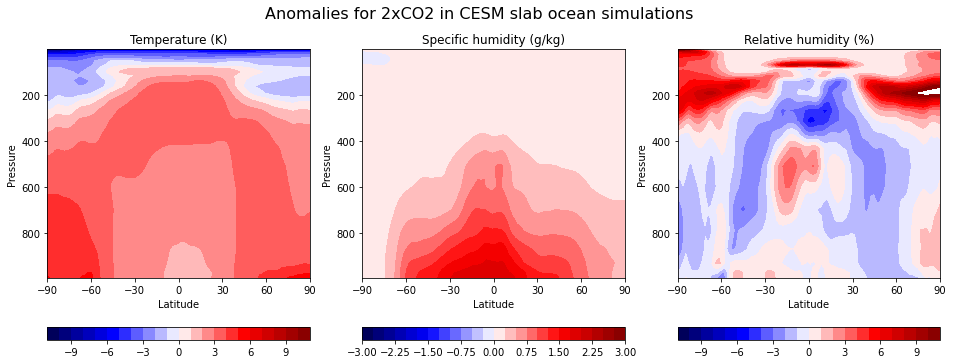

In [45]:
fig, ax = plt.subplots(1,3, figsize=(16,6))
for a in ax:
    a.invert_yaxis()
    a.set_xticks([-90, -60, -30, 0, 30, 60, 90]);
    a.set_xlabel('Latitude')
    a.set_ylabel('Pressure')
ctf = ax[0].contourf(ctrl.lat, ctrl.lev, (co2['T'] - ctrl['T']).mean(dim=('time','lon')), 
                 levels=np.arange(-11,12,1), cmap=plt.cm.seismic)
ax[0].set_title('Temperature (K)')
fig.colorbar(ctf, orientation='horizontal', ax=ax[0])
ctf = ax[1].contourf(ctrl.lat, ctrl.lev, (co2['Q'] - ctrl['Q']).mean(dim=('time','lon'))*1000,
                 levels=np.arange(-3,3.25,0.25), cmap=plt.cm.seismic)
ax[1].set_title('Specific humidity (g/kg)')
fig.colorbar(ctf, orientation='horizontal', ax=ax[1])
ctf = ax[2].contourf(ctrl.lat, ctrl.lev, (co2['RELHUM'] - ctrl['RELHUM']).mean(dim=('time','lon')),
                 levels=np.arange(-11,12,1), cmap=plt.cm.seismic)
ax[2].set_title('Relative humidity (%)')
fig.colorbar(ctf, orientation='horizontal', ax=ax[2])
fig.suptitle('Anomalies for 2xCO2 in CESM slab ocean simulations', fontsize=16);

### What do you see here?

- Where does the largest warming occur?
- Where does the largest moistening occur?

In fact the specific humidity anomaly has roughly the same shape of the specific humidity field itself -- **it is largest where the temperature is highest**. This is a consequence of the Clausius-Clapeyron relation.

The **relative humidity** anomaly is

- overall rather small (just a few percent)
- Largest in places cold places where the specific humidity is very small.

The smallness of the relative humidity change is a rather remarkable result.

This is not something we can derive from first principles. It is an emergent property of the GCMs. However it is a very robust feature of global warming simulations.

____________
<a id='section4'></a>

## 6. A simple water vapor parameterization
____________

### A credible climate model needs a water vapor feedback

If relative humidity is nearly constant under global warming, and water vapor is a greenhouse gas, this implies a positive feedback that will amplify the warming for a given radiative forcing.

Thus far our simple models have ignored this process, and we have not been able to use them to assess the climate sensitivity.

To proceed towards more realistic models, we have two options:

- **Simulate** all the evaporation, condensation and transport processes that determine the time-mean water vapor field (as is done in the CESM).
- **Parameterize** the dependence of water vapor on temperature by insisting that relative humidity stays constant as the climate changes.

We will now explore this second option, so that we can continue to think of the global energy budget under climate change as a process occurring in a single column.

### Manabe's constant relative humidity parameterization

We are going to adopt a parameterization first used in a very famous paper by {cite:t}`Manabe:1967aa`, *The thermal equilibrium of the atmosphere with a given distribution of relative humidity*.

This paper was the first to give a really credible calculation of climate sensitivity to a doubling of CO2 by accounting for the known spectral properties of CO2 and H2O absorption, as well as the water vapor feedback!

The parameterization is very simple:

We assume that the relative humidity $r$ is a linear function of pressure $p$:

$$ r = r_s \left( \frac{p/p_s - 0.02}{1 - 0.02} \right) $$

where $p_s = 1000$ hPa is the surface pressure, and $r_s$ is a prescribed surface value of relative humidity. Manabe and Wetherald set $r_s = 0.77$, but we should consider this a tunable parameter in our parameterization.

Since this formula gives a negative number above 20 hPa, we also assume that the **specific humidity** has a minimum value of $0.005$ g/kg (a typical stratospheric value).

This formula is implemented in `climlab.radiation.ManabeWaterVapor()`

Using this parameterization, the surface and tropospheric specific humidity will always increase as the temperature increases.

____________
<a id='section5'></a>

## 7. Modeling spectral bands with the `climlab.BandRCModel` process
____________

Here is a brief introduction to the `climlab.BandRCModel` process.

This is a model that divides the spectrum into 7 distinct bands: three shortwave and four longwave.

As we will see, the process works much like the familiar `climlab.RadiativeConvectiveModel`.

## About the spectra

### Shortwave

The shortwave is divided into three channels:

- Channel 0 is the Hartley and Huggins band (extreme UV, 200 - 340 nm, 1% of total flux, strong ozone absorption)
- Channel 1 is Chappuis band (450 - 800 nm, 27% of total flux, moderate ozone absorption)
- Channel 2 is remaining radiation (72% of total flux, largely in the visible range, no ozone absorption)




### Longwave

The longwave is divided into four bands:

- Band 0 is the **window region** (between 8.5 and 11 $\mu$m), 17% of total flux.
- Band 1 is the CO2 absorption channel (the band of strong absorption by CO2 around 15 $\mu$m), 15% of total flux
- Band 2 is a weak water vapor absorption channel, 35% of total flux
- Band 3 is a strong water vapor absorption channel, 33% of total flux

The longwave decomposition is not as easily related to specific wavelengths, as in reality there is a lot of overlap between H$_2$O and CO$_2$ absorption features (as well as absorption by other greenhouse gases such as CH$_4$ and N$_2$O that we are not representing).

### Example usage of the spectral model

In [10]:
import climlab
from climlab import constants as const

First try a model with all default parameters. Usage is very similar to the familiar `RadiativeConvectiveModel`.

In [11]:
col1 = climlab.BandRCModel()
col1.name = 'BandRCModel'
print(col1)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (30,) 
The subprocess tree: 
BandRCModel: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



Check out the list of subprocesses.

We now have a process called `H2O`, in addition to things we've seen before.

The state variables are still just temperatures:

In [12]:
col1.state

AttrDict({'Ts': Field([288.]), 'Tatm': Field([200.        , 202.68965517, 205.37931034, 208.06896552,
       210.75862069, 213.44827586, 216.13793103, 218.82758621,
       221.51724138, 224.20689655, 226.89655172, 229.5862069 ,
       232.27586207, 234.96551724, 237.65517241, 240.34482759,
       243.03448276, 245.72413793, 248.4137931 , 251.10344828,
       253.79310345, 256.48275862, 259.17241379, 261.86206897,
       264.55172414, 267.24137931, 269.93103448, 272.62068966,
       275.31034483, 278.        ])})

But the model has a new input field for specific humidity:

In [13]:
col1.q

Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
       5.87957411e-06, 8.55682965e-06, 1.22193649e-05, 1.71932832e-05,
       2.38916443e-05, 3.28354282e-05, 4.46774859e-05, 6.02302082e-05,
       8.04974602e-05, 1.06711275e-04, 1.40373783e-04, 1.83304857e-04,
       2.37695932e-04, 3.06170488e-04, 3.91851633e-04, 4.98437246e-04,
       6.30283118e-04, 7.92494475e-04, 9.91026303e-04, 1.23279279e-03,
       1.52578624e-03, 1.87920573e-03, 2.30359570e-03, 2.81099479e-03,
       3.41509495e-03, 4.13141097e-03])

The `H2O` process sets the specific humidity field at every timestep to a specified profile, determined by air temperatures. More on that below. For now, let's compute a radiative equilibrium state.

In [14]:
col1.integrate_years(2)

Integrating for 730 steps, 730.4844 days, or 2 years.
Total elapsed time is 1.9986737567564754 years.


In [15]:
# Check for energy balance
col1.ASR - col1.OLR

Field([-0.00148377])

In [16]:
#  Resuable function to plot the temperature data on a Skew-T chart
from metpy.plots import SkewT
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew
#  and a function to add extra profiles to this chart
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

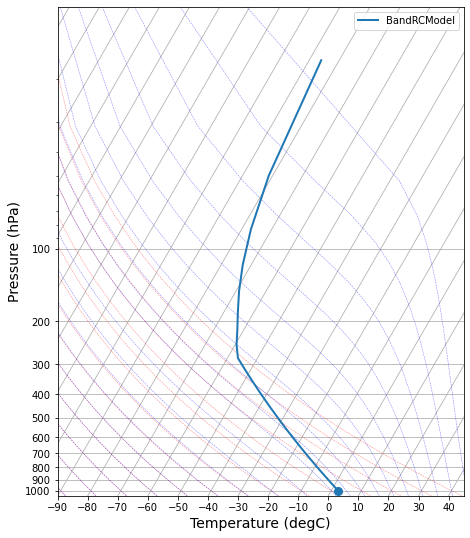

In [46]:
# Plot all the results
models = [col1]
skew = make_skewT()
for model in models:
  add_profile(skew, model)

By default this model has convective adjustment.  We can set the adjusted lapse rate by passing a parameter when we create the model.

The model currently has no ozone (so there is no stratosphere). Not very realistic!


### About the radiatively active gases

The Band model is aware of three different absorbing gases: O3 (ozone), CO2, and H2O (water vapor). The abundances of these gases are stored in a dictionary of arrays as follows:

In [18]:
col1.absorber_vmr

{'CO2': Field([0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038, 0.00038,
        0.00038, 0.00038]),
 'O3': Field([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'H2O': Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
        5.00000000e-06, 5.00000000e-06, 6.38590233e-06, 9.08848690e-06,
        1.33273826e-05, 2.34389689e-05, 3.84220914e-05, 5.95564299e-05,
        8.82144990e-05, 1.25843839e-04, 1.73951159e-04, 2.34088411e-04,
        3.07840683e-04, 3.96815735e-04, 5.02635028e-04, 6.26926041e-04,
        7.71315753e-04, 9.37425100e-04, 1.12686431e-03, 1.34122899e-03,
        1.58209684e-03, 1.85102493e-03, 2.14954752e-03, 2.47917415e-03,
        2.84138824e-03, 3.

Ozone and CO2 are both specified in the model. The default, as you see above, is zero ozone, and constant (well-mixed) CO2 at a volume mixing ratio of 3.8E-4 or 380 ppm.

Water vapor is handled differently: it is determined by the model at each timestep. We make the following assumptions, following a classic paper on radiative-convective equilibrium by Manabe and Wetherald (J. Atmos. Sci. 1967):

- the relative humidity just above the surface is fixed at 77% (can be changed of course... see the parameter `col1.relative_humidity`
- water vapor drops off linearly with pressure
- there is a small specified amount of water vapor in the stratosphere.

## Putting in some ozone

We need to provide some ozone data to the model in order to simulate a stratosphere. We will read in some ozone data just as we did in [the previous lecture on grey-gas modeling in climlab](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/grey-radiation-climlab.html#putting-stratospheric-ozone-in-the-grey-gas-model).

In [19]:
ozone = xr.open_dataset( datapath + 'som_input/ozone_1.9x2.5_L26_2000clim_c091112.nc')

In [20]:
#  Take global (area-weighted) and annual average
weight_ozone = cos(deg2rad(ozone.lat)) / cos(deg2rad(ozone.lat)).mean(dim='lat')
O3_global = (ozone.O3 * weight_ozone).mean(dim=('lat','lon','time'))
O3_global

<xarray.DataArray (lev: 26)>
array([7.82792878e-06, 8.64150529e-06, 7.58940028e-06, 5.24567145e-06,
       3.17761574e-06, 1.82320006e-06, 9.80756960e-07, 6.22870516e-07,
       4.47620550e-07, 3.34481169e-07, 2.62570302e-07, 2.07898125e-07,
       1.57074555e-07, 1.12425545e-07, 8.06004999e-08, 6.27826498e-08,
       5.42990561e-08, 4.99506089e-08, 4.60075681e-08, 4.22977789e-08,
       3.80559071e-08, 3.38768568e-08, 3.12171619e-08, 2.97807119e-08,
       2.87980968e-08, 2.75429934e-08])
Coordinates:
  * lev      (lev) float64 3.545 7.389 13.97 23.94 ... 867.2 929.6 970.6 992.6

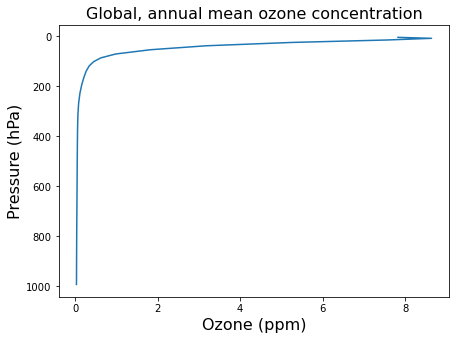

In [48]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot( O3_global*1E6, ozone.lev)
ax.invert_yaxis()
ax.set_xlabel('Ozone (ppm)', fontsize=16)
ax.set_ylabel('Pressure (hPa)', fontsize=16 )
ax.set_title('Global, annual mean ozone concentration', fontsize = 16);

We are going to create another instance of the model, this time using the same vertical coordinates as the ozone data.

In [22]:
#  Create the column with appropriate vertical coordinate, surface albedo and convective adjustment
col2 = climlab.BandRCModel(lev=ozone.lev)
col2.name = 'w/ O3'
print(col2)

climlab Process of type <class 'climlab.model.column.BandRCModel'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
The subprocess tree: 
w/ O3: <class 'climlab.model.column.BandRCModel'>
   LW: <class 'climlab.radiation.nband.FourBandLW'>
   SW: <class 'climlab.radiation.nband.ThreeBandSW'>
   insolation: <class 'climlab.radiation.insolation.FixedInsolation'>
   convective adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>
   H2O: <class 'climlab.radiation.water_vapor.ManabeWaterVapor'>



In [23]:
#  Set the ozone mixing ratio
col2.absorber_vmr['O3'] = O3_global.values

In [24]:
#  Run the model out to equilibrium!
col2.integrate_years(2.)

Integrating for 730 steps, 730.4844 days, or 2.0 years.
Total elapsed time is 1.9986737567564754 years.


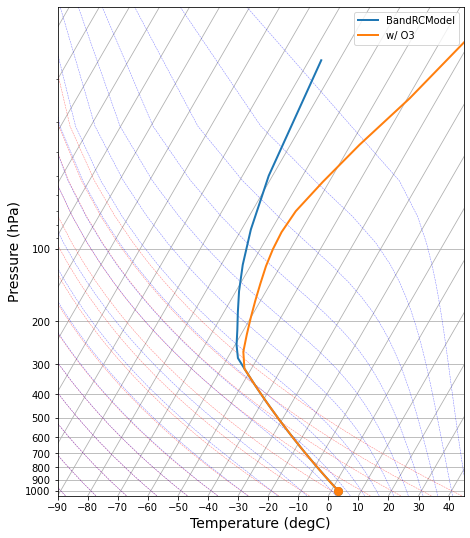

In [25]:
models.append(col2)
skew = make_skewT()
for model in models:
  add_profile(skew, model)

Once we include ozone we get a well-defined stratosphere. 

Things to consider / try:

- Here we used the global annual mean Q = 341.3 W m$^{-2}$. We might want to consider latitudinal or seasonal variations in Q.
- We also used the global annual mean ozone profile! Ozone varies tremendously in latitude and by season. That information is all contained in the ozone data file we opened above. We might explore the effects of those variations.
- We can calculate climate sensitivity in this model by doubling the CO2 concentration and re-running out to the new equilibrium. Does the amount of ozone affect the climate sensitivity?  (example below)
- An important shortcoming of the model: there are no clouds! (that would be the next step in the hierarchy of column models)
- Clouds would act both in the shortwave (increasing the albedo, cooling the climate) and in the longwave (greenhouse effect, warming the climate). Which effect is stronger depends on the vertical structure of the clouds (high or low clouds) and their optical properties (e.g. thin cirrus clouds are nearly transparent to solar radiation but are good longwave absorbers).

In [26]:
col3 = climlab.process_like(col2)
col3

In [27]:
# Let's double CO2.
col3.absorber_vmr['CO2'] *= 2.

In [28]:
col3.compute_diagnostics()
print( 'The radiative forcing for doubling CO2 is %f W/m2.' % (col2.diagnostics['OLR'] - col3.diagnostics['OLR']))

The radiative forcing for doubling CO2 is 1.390262 W/m2.


In [29]:
col3.integrate_years(3)

Integrating for 1095 steps, 1095.7266 days, or 3 years.
Total elapsed time is 4.996684391891189 years.


In [30]:
col3.ASR - col3.OLR

Field([4.2550937e-07])

In [31]:
print( 'The Equilibrium Climate Sensitivity is %f K.' % (col3.Ts - col2.Ts))

The Equilibrium Climate Sensitivity is 2.790202 K.


In [32]:
#  An example with no ozone
col4 = climlab.process_like(col1)
col4

In [33]:
col4.absorber_vmr['CO2'] *= 2.
col4.compute_diagnostics()
print('The radiative forcing for doubling CO2 is %f W/m2.' % (col1.OLR - col4.OLR))

The radiative forcing for doubling CO2 is 4.421081 W/m2.


In [34]:
col4.integrate_years(3.)
col4.ASR - col4.OLR

Integrating for 1095 steps, 1095.7266 days, or 3.0 years.
Total elapsed time is 4.996684391891189 years.


Field([-5.25654997e-07])

In [35]:
print('The Equilibrium Climate Sensitivity is %f K.' % (col4.Ts - col1.Ts))

The Equilibrium Climate Sensitivity is 3.180993 K.


Interesting that the model is MORE sensitive when ozone is set to zero.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany. It has been modified by [Nicole Feldl](http://nicolefeldl.com), UC Santa Cruz.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________